In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Conditional Pixel Diffusion Training

In this notebook, we will train a simple `PixelDiffusionConditional` model in low resolution (64 by 64) for **image translation**.

The training should take about 9 hours.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
```

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import lightning as L

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from precipitation.models.diffusion.lightning_pixel_diffusion import PixelDiffusionConditional

mpl.rcParams['figure.figsize'] = (8, 8)

/home/gregor/anaconda3/envs/precip_2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms=None,
                 paired=True,
                 return_pair=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair
        
        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )   
        
        # check files
        supported_formats=['webp','jpg']        
        self.files=[el for el in os.listdir(self.root_dir) if el.split('.')[-1] in supported_formats]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = image_to_tensor(io.imread(img_name))/255

        if self.paired:
            c,h,w=image.shape
            slice=int(w/2)
            image2=image[:,:,slice:]
            image=image[:,:,:slice]
            if self.transforms is not None:
                out = self.input_T(image,image2)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            image = self.input_T(image)[0]

        if self.return_pair:
            return image2,image
        else:
            return image

In [4]:
CROP_SIZE=64

T=[
    KA.RandomCrop((2*CROP_SIZE,2*CROP_SIZE)),
    KA.Resize((CROP_SIZE,CROP_SIZE),antialias=True),
    KA.RandomVerticalFlip()
  ]

train_ds=SimpleImageDataset('/home/gregor/datasets/maps/train',
                      transforms=T,
                      return_pair=True
                     )

val_ds=SimpleImageDataset('/home/gregor/datasets/maps/val',
                      transforms=T,
                      return_pair=True
                     )

### Model Training

In [5]:
model=PixelDiffusionConditional(train_ds,
                                val_ds,
                                lr=1e-4,
                                batch_size=16)

Is Time embed used ?  True


In [6]:
from lightning.pytorch.callbacks import StochasticWeightAveraging


class EMACallback(StochasticWeightAveraging):
    def __init__(self, swa_lrs=1.e-4, decay=0.9999):
        super().__init__(swa_lrs)
        self.decay=decay
    
    def avg_fn(averaged_model_parameter: torch.Tensor, model_parameter: torch.Tensor, num_averaged: torch.LongTensor) -> torch.FloatTensor:
        return averaged_model_parameter * self.decay + (1. - self.decay) * model

In [7]:
trainer = L.Trainer(
    precision="16-mixed",
    max_steps=10000,
    callbacks=[EMACallback(0.9999)],
    devices=[1]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.479   Total estimated model params size (MB)


Epoch 144:  93%|█████████▎| 64/69 [00:05<00:00, 12.44it/s, v_num=8]        

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 144:  93%|█████████▎| 64/69 [00:06<00:00, 10.32it/s, v_num=8]


In [9]:
input,output=val_ds[0]
batch_input=torch.stack(4*[input],0)

model.cuda()
out=model(batch_input, verbose=True)

diffusion sampling: 100%|██████████| 1000/1000 [00:12<00:00, 80.07it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

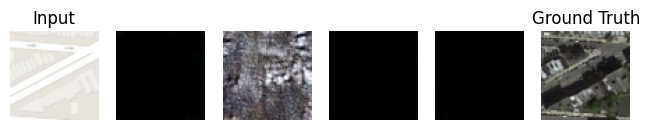

In [10]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

Gregor: Looks like 10k steps aren't enough for conditional generation. Will be interesting to see how this might change with the "conditioning hack".

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

In [ ]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)
STEPS=200 # ddim steps

ddim_sampler=DDIM_Sampler(STEPS,model.model.num_timesteps)

model.cuda()
out=model(batch_input,sampler=ddim_sampler,verbose=True)

In [ ]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')